In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from sklearn.base import clone
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, SGD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


print(tf.__version__)

2.10.0


In [36]:
def get_group_data(group):
    data_list = []
    dt_list = []
    filename_list = []

    for key in group.keys():
        
        for key2 in group[key].keys():

            dt = datetime.strptime(' '.join([key.split('__')[-2], key.split('__')[-1].replace('-', ':')]), 
                                        "%Y-%m-%d %H:%M:%S:%f")
            data = np.array(group[key][key2])
            data_list.append(data)
            dt_list.append(dt)
            filename_list.append(key2)
    
    df = pd.DataFrame({'filename': filename_list, 'data': data_list, 'dt': dt_list})
    return df

def get_translations(positive, negative):
    x_translation_list = []
    y_translation_list = []
    dt_list = []

    for i in range(len(positive['data'])):
        data = positive['data'][i]
        x_translation = data[0, 3]
        y_translation = data[2, 3]
        dt = positive['dt'][i].strftime('%H:%M:%S')
        x_translation_list.append(x_translation)
        y_translation_list.append(y_translation)
        dt_list.append(dt)

    positive_df = pd.DataFrame({'x_translation': x_translation_list, 'y_translation': y_translation_list, 'dt': dt_list})

    x_translation_list = []
    y_translation_list = []
    dt_list = []

    for i in range(len(negative['data'])):
        data = negative['data'][i]
        x_translation = data[0, 3]
        y_translation = data[2, 3]
        dt = negative['dt'][i].strftime('%H:%M:%S')
        x_translation_list.append(x_translation)
        y_translation_list.append(y_translation)
        dt_list.append(dt)

    negative_df = pd.DataFrame({'x_translation': x_translation_list, 'y_translation': y_translation_list, 'dt': dt_list})

    return positive_df, negative_df

def plot_translations(positive_df, negative_df):
    positive_df['type'] = 'Positive'
    negative_df['type'] = 'Negative'

    df = pd.concat([positive_df, negative_df])

    df = df.melt(id_vars=['dt', 'type'], value_vars=['x_translation', 'y_translation'], var_name='axis', value_name='translation')

    g = sns.relplot(data=df, x='dt', y='translation', hue='axis', col='type', kind='line')

    # Reduce the number of x-axis labels
    x_ticks = g.axes[0][0].get_xticks()
    g.set(xticks=x_ticks[::10])
    g.set_xticklabels(df['dt'].unique()[::10], rotation=45)

    # Update axis titles
    g.set_axis_labels('Time', 'Translation')    
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    
    plt.show()


def plot_loss(history, num_epochs):
    plt.plot(history.history['loss'][:num_epochs], label='loss')
    plt.plot(history.history['val_loss'][:num_epochs], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [mm]')
    plt.legend()
    plt.grid(True)


def build_and_compile_model(train_features, train_labels, n_trials=100): #, epochs=500):
    def objective(trial):
        if trial.number ==0:
            learning_rate = 0.0017172015688603477
            beta_1 =  0.8539642649814688
            beta_2 = 0.9358548594051231
            clipvalue = 0.964758137195115
            batch_size=32
            num_layers = 3
            num_neurons = 112
            activation = 'tanh'
            l1=4.5927655210613596e-08 
            l2=6.769705259483123e-10
            optimizer_name = 'adam'
            scaler_name='standard_scaler'
            loss_name = 'huber_loss'
            epochs=500
        else:   
            # Define the search space for the hyperparameters
            learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-0, log=True)
            # beta_1 = trial.suggest_uniform('beta_1', 0.8, 0.99)
            # beta_2 = trial.suggest_uniform('beta_2', 0.9, 0.999)
            #clipvalue = trial.suggest_uniform('clipvalue', 0.1, 1.0)
            #batch_size = trial.suggest_int('batch_size', 32, 256, 32)
            #num_layers = trial.suggest_int('num_layers', 1, 5)
            #num_neurons = trial.suggest_int('num_neurons', 16, 128, 16)
            #activation = trial.suggest_categorical('activation', ['sigmoid', 'tanh', 'relu']) #'linear', 
            # l1 = trial.suggest_float('l1', 1e-10, 1e-2, log=True)
            # l2 = trial.suggest_float('l2', 1e-10, 1e-2, log=True)
            #optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
            #loss_name = trial.suggest_categorical('loss', ['mean_absolute_error', 'mean_squared_error', 'huber_loss']) #, 'log_cosh'])
            #scaler_name = trial.suggest_categorical('scaler', ['normalizer', 'standard_scaler'])
            # epochs = trial.suggest_int('epochs', 100, 1000)


            learning_rate = 0.0017172015688603477
            beta_1 =  0.8539642649814688
            beta_2 = 0.9358548594051231
            clipvalue =0.964758137195115
            batch_size=32
            num_layers = 3
            num_neurons = 112
            activation = 'tanh'
            l1=4.5927655210613596e-08 
            l2=6.769705259483123e-10
            optimizer_name = 'adam'
            scaler_name='standard_scaler'
            loss_name = 'huber_loss'
            epochs=500

        # Scale the data
        if scaler_name == 'normalizer':
            scaler = MinMaxScaler()
            scaled_train_features = scaler.fit_transform(train_features)
        elif scaler_name == 'standard_scaler':
            scaler = StandardScaler()
            scaled_train_features = scaler.fit_transform(train_features)

        # scaled_train_features = tf.keras.layers.Normalization(axis=-1)
        # scaled_train_features.adapt(np.array(train_features))

        # Create a neural network model
        model = keras.Sequential()
        for i in range(num_layers):
            model.add(layers.Dense(num_neurons, activation=activation, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
        # model.add(layers.Dense(16))
        model.add(layers.Reshape((1,112)))
        model.add(layers.SimpleRNN(112, activation='tanh'))
        model.add(layers.Dense(3))

        # Define the optimizer with the given hyperparameters
        if optimizer_name == 'adam':
            optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, clipvalue=clipvalue)
        elif optimizer_name == 'sgd':
            optimizer = SGD(learning_rate=learning_rate, clipvalue=clipvalue)
        elif optimizer_name == 'rmsprop':
            optimizer = RMSprop(learning_rate=learning_rate, clipvalue=clipvalue)

        # Compile the model
        model.compile(loss=loss_name, optimizer=optimizer, metrics=['accuracy']) #'val_accuracy', , 'loss', 'val_loss'

        # Train the model on the training data and validate on a validation split
        early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=30)
        history = model.fit(scaled_train_features, train_labels, validation_split=0.2, verbose=0, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

        # Evaluate the final performance of the model on the validation data
        val_loss = history.history['val_loss'][-1]

        return val_loss

    # Run the hyperparameter tuning
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_params

    # Scale the data with the best scaler
    if best_params['scaler'] == 'normalizer':
        scaler = MinMaxScaler()
        scaled_train_features = scaler.fit_transform(train_features)
    elif best_params['scaler'] == 'standard_scaler':
        scaler = StandardScaler()
        scaled_train_features = scaler.fit_transform(train_features)

    # Create a neural network model with the best hyperparameters
    model = keras.Sequential()
    for i in range(best_params['num_layers']):
        model.add(layers.Dense(best_params['num_neurons'], activation=best_params['activation'], kernel_regularizer=regularizers.l1_l2(l1=best_params['l1'], l2=best_params['l2'])))
    # model.add(layers.Dense(16))
    model.add(layers.Dense(3))

    # Define the optimizer with the best hyperparameters
    if best_params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'], beta_1=best_params['beta_1'], beta_2=best_params['beta_2'], clipvalue=best_params['clipvalue'])
    elif best_params['optimizer'] == 'sgd':
        optimizer = SGD(learning_rate=best_params['learning_rate'], clipvalue=best_params['clipvalue'])
    elif best_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=best_params['learning_rate'], clipvalue=best_params['clipvalue'])

    # Compile the model
    model.compile(loss=best_params['loss'], optimizer=optimizer)

    return model, best_params


In [15]:
# Get a list of all H5 files
# h5_files = glob.glob('scanner3DTop_Transformations/TESTDATASET_*/*.h5')
h5_files = glob.glob('scanner3DTop_Transformations/**/**/**.h5', recursive= True)

df_list = []

for h5_file in h5_files:

    # Open H5 file
    h5 = h5py.File(h5_file, 'r')
    keys = list(h5.keys())
    
    if "EW" in keys and "NS" in keys and "environment_logger" in keys:

        # Get negative direction transformations
        negative = get_group_data(group=h5["EW/individual/transformations/negative/"])

        # Get positive direction transformations
        positive = get_group_data(group=h5["EW/individual/transformations/positive/"])

        # Combine positive and negative transformations
        transformations = pd.concat([positive, negative])

        # Extract Environment Logger data
        df = pd.read_hdf(h5_file, 'environment_logger') 

        # Merge transformations and Environment logger data
        df = df.merge(transformations, on='filename')

        # Drop unwanted columns
        df = df.drop(['directories', 'filename', 'dt'], axis=1)

        # Flatten the transformations
        df['data'] = df['data'].apply(lambda x: x.flatten())

        df['field'] = df['field'].map({'north': 0.0, 'south': 1.0})
        df['scan_direction'] = df['scan_direction'].map({'Negative': 0.0, 'Positive': 1.0})
        df = df.drop(['brightness'], axis=1) #, 'time'

        # Reset the index of your DataFrame
        df = df.reset_index(drop=True)

        # Add to list
        df_list.append(df)

df = pd.concat(df_list)
df = df.dropna()
df = df.reset_index(drop=True)

In [16]:
# Extract X, Y, Z transformations
df['data'] = df['data'].apply(lambda x: x.reshape(4, 4)[:3,3])#[:3])
# df['data'] = df['data'].astype('float')

In [17]:
df2= df.drop(['time', 'par','field', 'x_position', 'y_position', 'z_position'], axis=1)

In [18]:
df

,time,sunDirection,airPressure,relHumidity,temperature,windDirection,precipitation,windVelocity,par,field,x_position,y_position,z_position,scan_direction,data
0,2022-05-05 23:09:24,338.213446,1010.343944,19.568468,25.102084,173.380535,0.089503,3.887448,0.000000,0.0,303.8460,0.000,1.234,1.0,"[-15.0, -15.0, 0.0]"
1,2022-05-05 23:11:12,338.707846,1010.407422,19.681387,25.071566,171.128269,0.089503,3.416852,0.000000,0.0,304.5450,22.135,1.234,0.0,"[-10.0, 15.0, 0.0]"
2,2022-05-05 23:13:01,339.213233,1010.383618,19.989624,24.931181,171.402936,0.086451,3.394879,1.465023,0.0,305.2460,0.000,1.234,1.0,"[-20.0, -15.0, 0.0]"
3,2022-05-05 23:14:50,339.707633,1010.296335,19.870602,24.949492,162.470779,0.089503,3.050630,0.000000,0.0,305.9455,22.135,1.234,0.0,"[-15.0, 10.0, 0.0]"
4,2022-05-05 23:16:38,340.311899,1010.256661,19.965209,24.827418,158.658406,0.086451,3.517563,0.000000,0.0,306.6455,0.000,1.234,1.0,"[-10.0, -10.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4248,2023-07-21 16:27:18,272.403333,1004.527726,16.840114,44.298227,268.008667,0.110866,6.912442,1120.253937,0.0,304.5460,22.135,2.319,0.0,"[115.0, 85.0, 0.0]"
4249,2023-07-21 16:29:13,272.721946,1004.511856,17.099521,44.578997,273.732719,0.104762,4.070559,1103.162007,0.0,305.2460,3.800,2.319,1.0,"[120.0, 30.0, 0.0]"
4250,2023-07-21 16:31:07,272.919706,1004.503922,17.221595,44.548479,265.437788,0.104762,6.286203,1090.953486,0.0,305.9460,22.135,2.319,0.0,"[25.0, -15.0, 0.0]"
4251,2023-07-21 16:33:00,273.216346,1004.456313,17.334513,44.426405,269.436934,0.104762,4.409314,1073.373215,0.0,306.6455,3.800,2.319,1.0,"[390.0, 250.0, 0.0]"


In [19]:
dataset = df2
dataset = dataset.reset_index(drop=True)

# Convert any Timestamps in the input features to a numerical representation
# dataset = dataset.apply(lambda x: x.astype(int) if np.issubdtype(x.dtype, np.datetime64) else x)
#dataset['time'] = dataset['time'].values.astype(int)

# Convert only the columns with numeric data types to float
#dataset[dataset.select_dtypes(include='number').columns] = dataset.select_dtypes(include='number').astype(float)

In [20]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index, axis=0)

In [21]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('data')
test_labels = test_features.pop('data')

In [22]:
train_labels = train_labels.tolist()
train_labels = np.array(train_labels)

test_labels = test_labels.tolist()
test_labels = np.array(test_labels)

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow.keras.backend as k

In [24]:
train_features.shape

(3402, 8)

In [ ]:
dnn_model, best_parameters = build_and_compile_model(train_features=train_features, train_labels=train_labels, n_trials=100)
dnn_model.build(input_shape=(None, train_features.shape[1]))
dnn_model.summary()

[I 2024-01-11 04:43:29,715] A new study created in memory with name: no-name-4bbadd99-d8ae-4730-83d0-46d7a6dd41ff
[I 2024-01-11 04:48:55,121] Trial 0 finished with value: 8.481119155883789 and parameters: {}. Best is trial 0 with value: 8.481119155883789.
[I 2024-01-11 04:56:19,509] Trial 1 finished with value: 8.60782241821289 and parameters: {'learning_rate': 0.009343980237730289}. Best is trial 0 with value: 8.481119155883789.
[I 2024-01-11 05:03:45,001] Trial 2 finished with value: 8.68367862701416 and parameters: {'learning_rate': 0.0011346746561896515}. Best is trial 0 with value: 8.481119155883789.
[I 2024-01-11 05:11:15,377] Trial 3 finished with value: 8.198264122009277 and parameters: {'learning_rate': 0.10514088102386045}. Best is trial 3 with value: 8.198264122009277.
[I 2024-01-11 05:15:41,606] Trial 4 finished with value: 11.535700798034668 and parameters: {'learning_rate': 0.007908072847787745}. Best is trial 3 with value: 8.198264122009277.
[I 2024-01-11 05:22:57,620] T

In [ ]:
# Scale the data with the best scaler
if best_parameters['scaler'] == 'normalizer':
    scaler = MinMaxScaler()
    scaled_train_features = scaler.fit_transform(train_features)
elif best_parameters['scaler'] == 'standard_scaler':
    scaler = StandardScaler()
    scaled_train_features = scaler.fit_transform(train_features)

In [27]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = dnn_model.fit(
    scaled_train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, 
    epochs=best_parameters['epochs'],
    batch_size=best_parameters['batch_size'],
    use_multiprocessing=True,
    callbacks=[early_stopping])

Epoch 1/850
15/15 [==============================] - 1s 33ms/step - loss: 31.9655 - val_loss: 33.7600
Epoch 2/850
15/15 [==============================] - 0s 17ms/step - loss: 30.8660 - val_loss: 32.6985
Epoch 3/850
15/15 [==============================] - 0s 6ms/step - loss: 30.4115 - val_loss: 32.4448
Epoch 4/850
15/15 [==============================] - 0s 7ms/step - loss: 30.1802 - val_loss: 31.8941
Epoch 5/850
15/15 [==============================] - 0s 5ms/step - loss: 29.6975 - val_loss: 31.4118
Epoch 6/850
15/15 [==============================] - 0s 6ms/step - loss: 29.3307 - val_loss: 31.0647
Epoch 7/850
15/15 [==============================] - 0s 5ms/step - loss: 29.0517 - val_loss: 30.8022
Epoch 8/850
15/15 [==============================] - 0s 5ms/step - loss: 28.7853 - val_loss: 30.6172
Epoch 9/850
15/15 [==============================] - 0s 5ms/step - loss: 28.5324 - val_loss: 30.4550
Epoch 10/850
15/15 [==============================] - 0s 5ms/step - loss: 28.3704 - val_l

In [28]:
np.min(history.history['val_loss'])

4.958810329437256

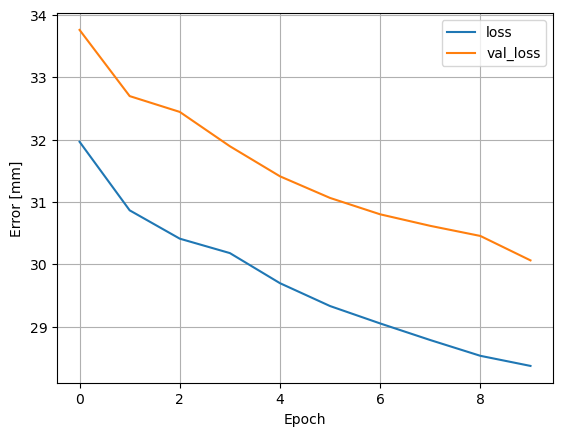

In [40]:
plot_loss(history, num_epochs=10)

plt.savefig('plot_loss_original.png', bbox_inches='tight')

In [30]:
test_labels[0][0]

-15.0

In [31]:
test_predictions = dnn_model.predict(test_features)

27/27 [==============================] - 0s 3ms/step


In [32]:
test_predictions[0][1]

49.41953

In [33]:
test_labels[0]

array([-15., -15.,   0.])

In [34]:
test_predictions.shape

(851, 3)

27/27 [==============================] - 0s 4ms/step


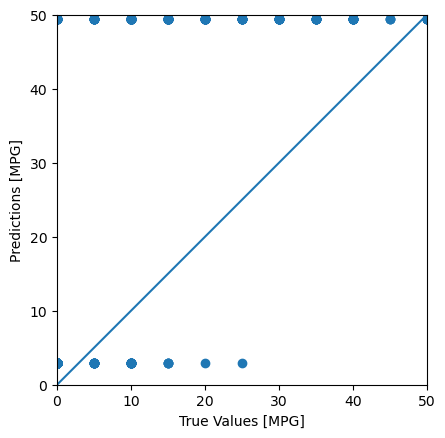

In [39]:
test_predictions = dnn_model.predict(test_features)#.flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
fig = plt.plot(lims, lims)

plt.savefig('test_predictions_original.png', bbox_inches='tight')